# Premier League Football Data - EDA Part 3

## Match Analytics Deep Dive

This notebook focuses on match-level analytics including:
- Score distributions and goal patterns
- High-scoring and low-scoring matches
- xG prediction accuracy
- Match outcome patterns by gameweek
- Referee analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['font.size'] = 11

# Data paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

# Load data
fixtures = pd.read_csv(PROCESSED_DIR / 'all_fixtures.csv')

# Add derived columns
fixtures['total_goals'] = fixtures['home_goals'] + fixtures['away_goals']
fixtures['total_xg'] = fixtures['home_xg'] + fixtures['away_xg']
fixtures['goal_diff'] = fixtures['home_goals'] - fixtures['away_goals']
fixtures['xg_diff'] = fixtures['home_xg'] - fixtures['away_xg']
fixtures['xg_prediction_error'] = fixtures['total_goals'] - fixtures['total_xg']

display(Markdown(f"""
✅ **Data loaded successfully!**

**Total Matches:** {len(fixtures):,}
"""))


✅ **Data loaded successfully!**

**Total Matches:** 2,110


## 1. Score Distribution Analysis

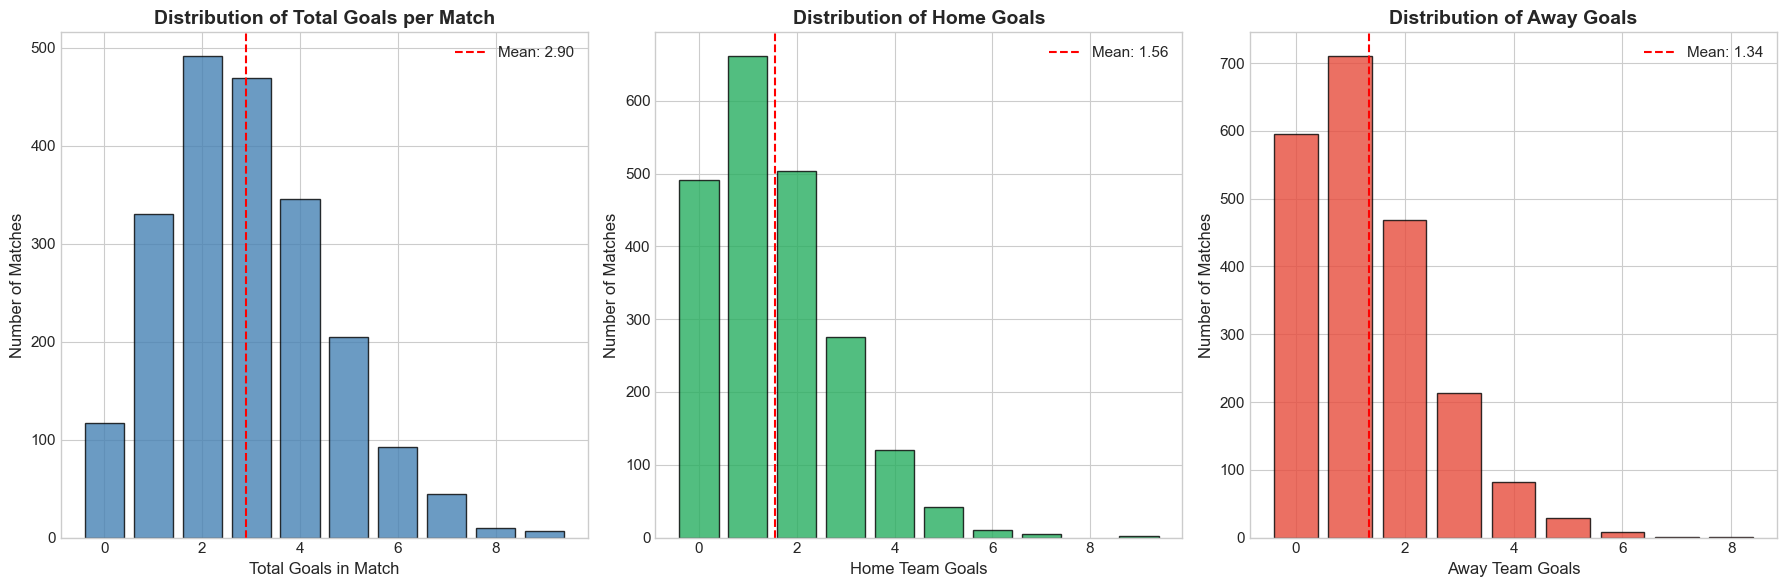


## 📊 Goal Statistics

| Metric | Value |
|--------|-------|
| Average Goals per Match | **2.90** |
| Median Goals per Match | **3** |
| Max Goals in a Match | **9** |


In [2]:
# Total goals distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total goals per match
goal_counts = fixtures['total_goals'].value_counts().sort_index()
axes[0].bar(goal_counts.index, goal_counts.values, color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Total Goals in Match', fontsize=12)
axes[0].set_ylabel('Number of Matches', fontsize=12)
axes[0].set_title('Distribution of Total Goals per Match', fontsize=14, fontweight='bold')
axes[0].axvline(fixtures['total_goals'].mean(), color='red', linestyle='--', label=f"Mean: {fixtures['total_goals'].mean():.2f}")
axes[0].legend()

# Home goals distribution
home_counts = fixtures['home_goals'].value_counts().sort_index()
axes[1].bar(home_counts.index, home_counts.values, color='#27ae60', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Home Team Goals', fontsize=12)
axes[1].set_ylabel('Number of Matches', fontsize=12)
axes[1].set_title('Distribution of Home Goals', fontsize=14, fontweight='bold')
axes[1].axvline(fixtures['home_goals'].mean(), color='red', linestyle='--', label=f"Mean: {fixtures['home_goals'].mean():.2f}")
axes[1].legend()

# Away goals distribution
away_counts = fixtures['away_goals'].value_counts().sort_index()
axes[2].bar(away_counts.index, away_counts.values, color='#e74c3c', edgecolor='black', alpha=0.8)
axes[2].set_xlabel('Away Team Goals', fontsize=12)
axes[2].set_ylabel('Number of Matches', fontsize=12)
axes[2].set_title('Distribution of Away Goals', fontsize=14, fontweight='bold')
axes[2].axvline(fixtures['away_goals'].mean(), color='red', linestyle='--', label=f"Mean: {fixtures['away_goals'].mean():.2f}")
axes[2].legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/goal_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

display(Markdown(f"""
## 📊 Goal Statistics

| Metric | Value |
|--------|-------|
| Average Goals per Match | **{fixtures['total_goals'].mean():.2f}** |
| Median Goals per Match | **{fixtures['total_goals'].median():.0f}** |
| Max Goals in a Match | **{fixtures['total_goals'].max():.0f}** |
"""))

## 2. Most Common Scorelines

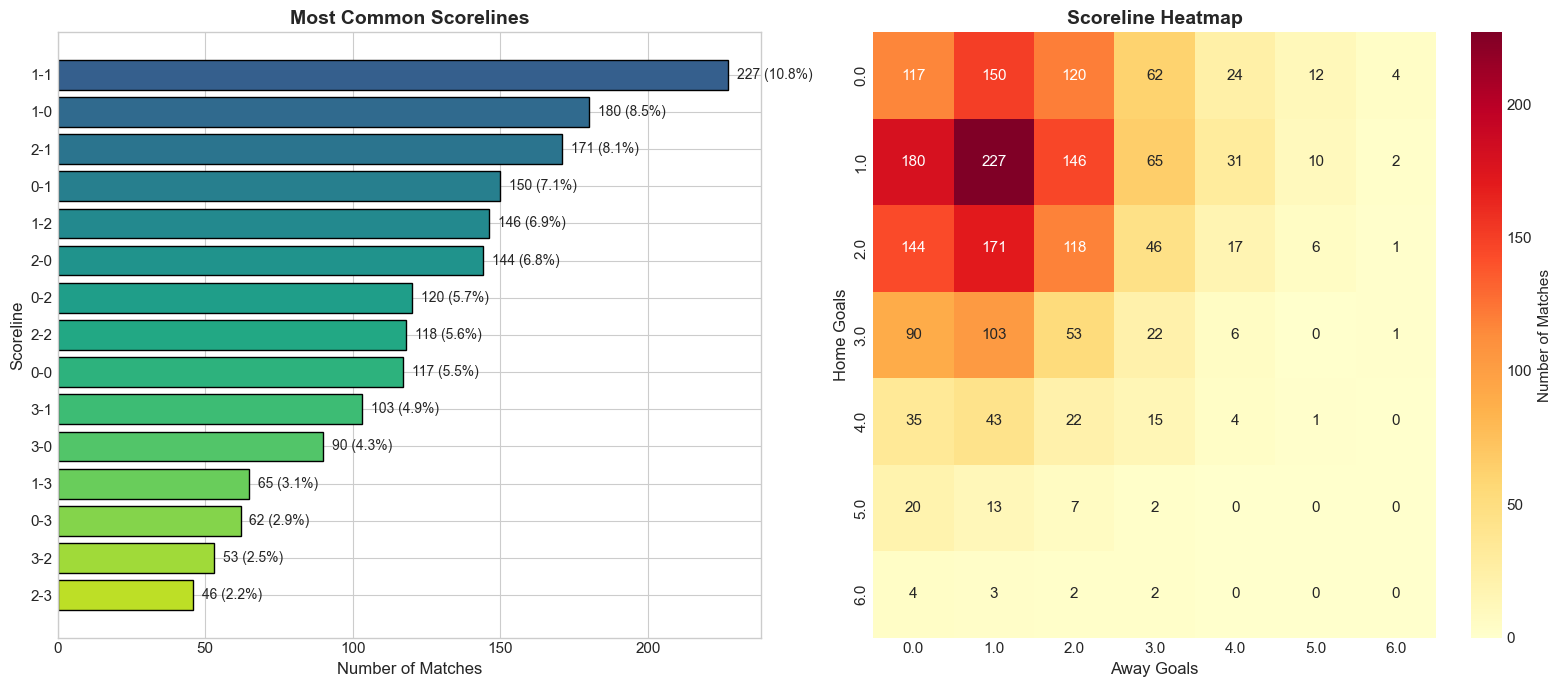

In [3]:
# Create scoreline column
fixtures['scoreline'] = fixtures['home_goals'].astype(int).astype(str) + '-' + fixtures['away_goals'].astype(int).astype(str)

# Top 15 most common scorelines
scoreline_counts = fixtures['scoreline'].value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Bar chart
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(scoreline_counts)))
bars = axes[0].barh(scoreline_counts.index[::-1], scoreline_counts.values[::-1], color=colors[::-1], edgecolor='black')
axes[0].set_xlabel('Number of Matches', fontsize=12)
axes[0].set_ylabel('Scoreline', fontsize=12)
axes[0].set_title('Most Common Scorelines', fontsize=14, fontweight='bold')

for bar, val in zip(bars, scoreline_counts.values[::-1]):
    axes[0].text(val + 3, bar.get_y() + bar.get_height()/2, f'{val} ({val/len(fixtures)*100:.1f}%)', 
                 va='center', fontsize=10)

# Heatmap of scorelines
scoreline_matrix = fixtures.pivot_table(index='home_goals', columns='away_goals', 
                                         aggfunc='size', fill_value=0)
# Keep only reasonable goal counts
scoreline_matrix = scoreline_matrix.loc[0:6, 0:6]

sns.heatmap(scoreline_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], 
            cbar_kws={'label': 'Number of Matches'})
axes[1].set_xlabel('Away Goals', fontsize=12)
axes[1].set_ylabel('Home Goals', fontsize=12)
axes[1].set_title('Scoreline Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/scoreline_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. xG Prediction Accuracy

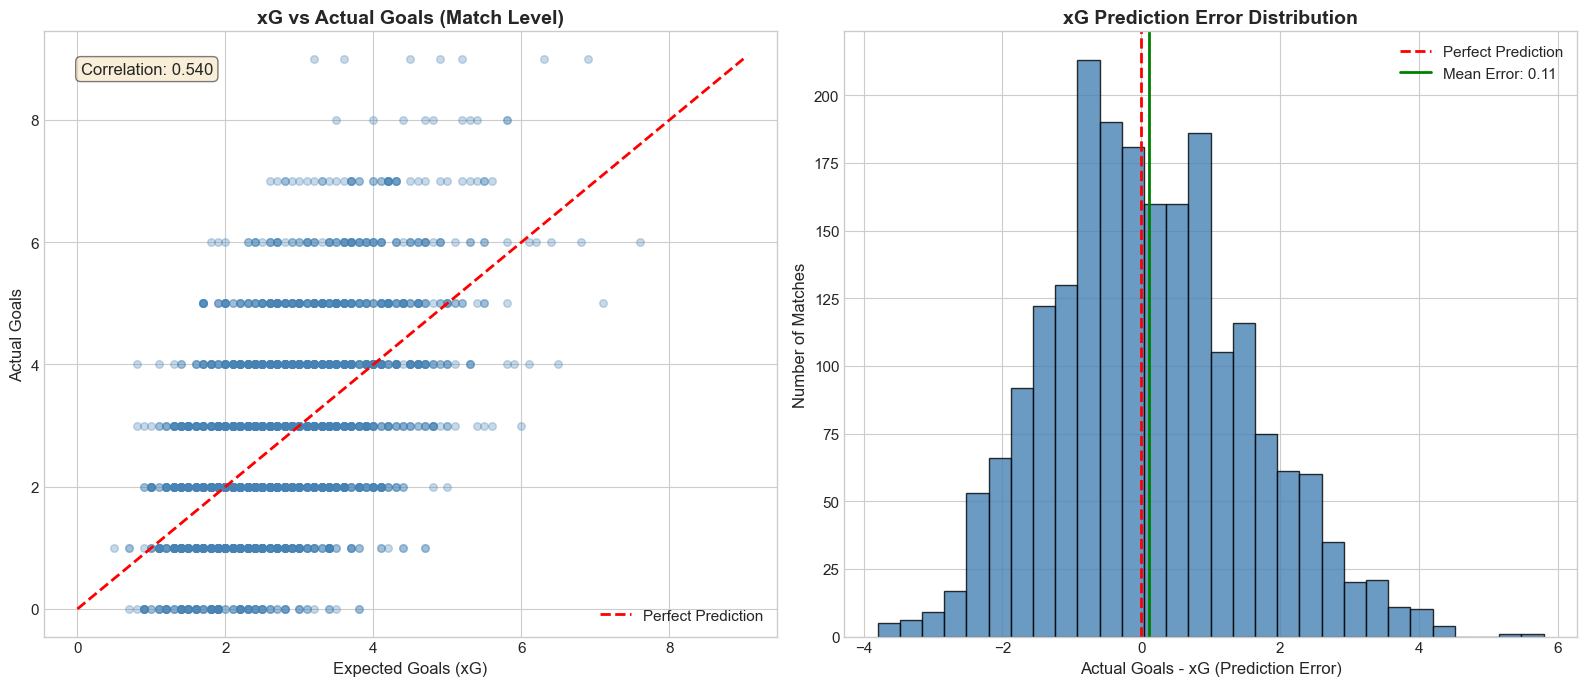


## 🎯 xG Prediction Statistics

| Metric | Value |
|--------|-------|
| Mean Absolute Error | **1.14** goals |
| Root Mean Square Error | **1.43** goals |
| Matches within ±1 goal of xG | **53.9%** |


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# xG vs Actual Goals scatter
axes[0].scatter(fixtures['total_xg'], fixtures['total_goals'], alpha=0.3, s=30, c='steelblue')
max_val = max(fixtures['total_xg'].max(), fixtures['total_goals'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Expected Goals (xG)', fontsize=12)
axes[0].set_ylabel('Actual Goals', fontsize=12)
axes[0].set_title('xG vs Actual Goals (Match Level)', fontsize=14, fontweight='bold')
axes[0].legend()

# Correlation
corr = fixtures['total_xg'].corr(fixtures['total_goals'])
axes[0].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[0].transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# xG prediction error distribution
axes[1].hist(fixtures['xg_prediction_error'], bins=30, color='steelblue', edgecolor='black', alpha=0.8)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[1].axvline(fixtures['xg_prediction_error'].mean(), color='green', linestyle='-', 
                linewidth=2, label=f"Mean Error: {fixtures['xg_prediction_error'].mean():.2f}")
axes[1].set_xlabel('Actual Goals - xG (Prediction Error)', fontsize=12)
axes[1].set_ylabel('Number of Matches', fontsize=12)
axes[1].set_title('xG Prediction Error Distribution', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/xg_prediction_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

display(Markdown(f"""
## 🎯 xG Prediction Statistics

| Metric | Value |
|--------|-------|
| Mean Absolute Error | **{fixtures['xg_prediction_error'].abs().mean():.2f}** goals |
| Root Mean Square Error | **{np.sqrt((fixtures['xg_prediction_error']**2).mean()):.2f}** goals |
| Matches within ±1 goal of xG | **{(fixtures['xg_prediction_error'].abs() <= 1).mean()*100:.1f}%** |
"""))

## 4. Goal Patterns by Gameweek

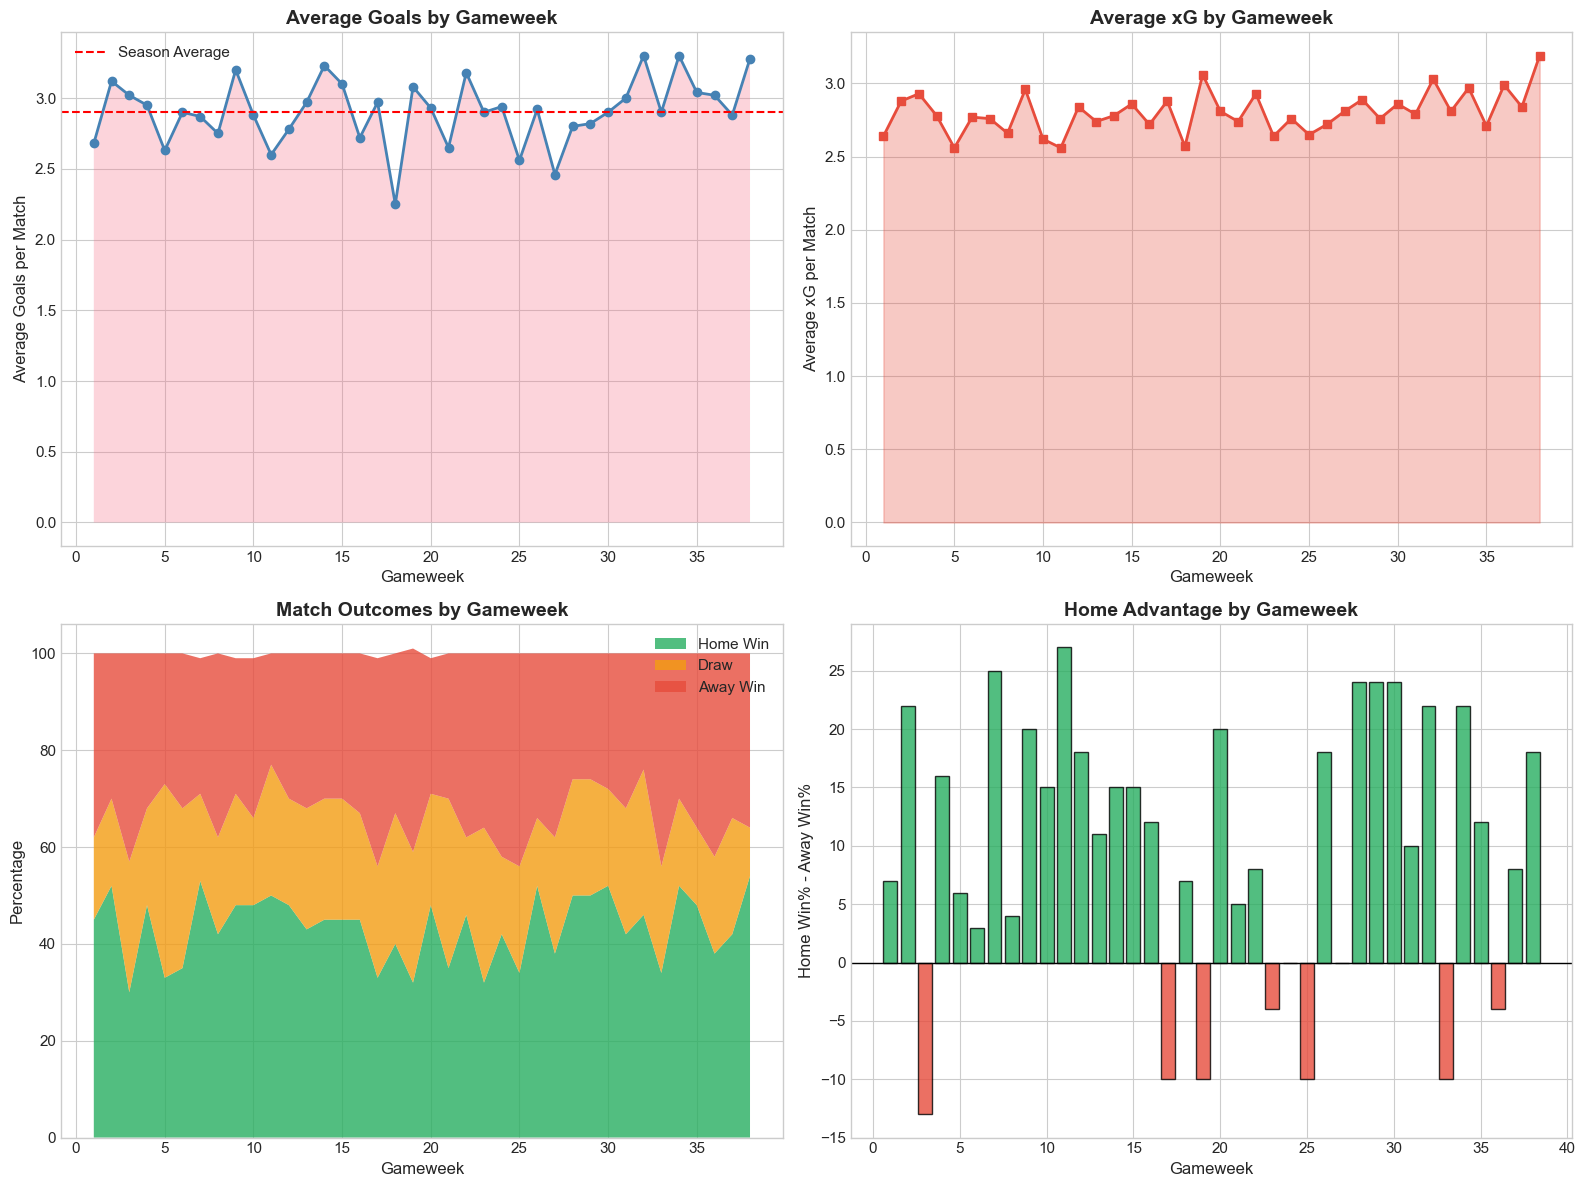

In [5]:
# Goals by gameweek
gameweek_stats = fixtures.groupby('gameweek').agg({
    'total_goals': ['mean', 'sum'],
    'total_xg': 'mean',
    'match_result': [lambda x: (x == 2).mean(), lambda x: (x == 0).mean(), lambda x: (x == 1).mean()]
}).round(2)
gameweek_stats.columns = ['avg_goals', 'total_goals', 'avg_xg', 'home_win_pct', 'away_win_pct', 'draw_pct']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average goals by gameweek
axes[0, 0].plot(gameweek_stats.index, gameweek_stats['avg_goals'], marker='o', linewidth=2, color='steelblue')
axes[0, 0].axhline(fixtures['total_goals'].mean(), color='red', linestyle='--', label='Season Average')
axes[0, 0].fill_between(gameweek_stats.index, gameweek_stats['avg_goals'], alpha=0.3)
axes[0, 0].set_xlabel('Gameweek', fontsize=12)
axes[0, 0].set_ylabel('Average Goals per Match', fontsize=12)
axes[0, 0].set_title('Average Goals by Gameweek', fontsize=14, fontweight='bold')
axes[0, 0].legend()

# xG by gameweek
axes[0, 1].plot(gameweek_stats.index, gameweek_stats['avg_xg'], marker='s', linewidth=2, color='#e74c3c')
axes[0, 1].fill_between(gameweek_stats.index, gameweek_stats['avg_xg'], alpha=0.3, color='#e74c3c')
axes[0, 1].set_xlabel('Gameweek', fontsize=12)
axes[0, 1].set_ylabel('Average xG per Match', fontsize=12)
axes[0, 1].set_title('Average xG by Gameweek', fontsize=14, fontweight='bold')

# Win/Draw/Loss percentages by gameweek
axes[1, 0].stackplot(gameweek_stats.index, 
                     gameweek_stats['home_win_pct']*100, 
                     gameweek_stats['draw_pct']*100, 
                     gameweek_stats['away_win_pct']*100,
                     labels=['Home Win', 'Draw', 'Away Win'],
                     colors=['#27ae60', '#f39c12', '#e74c3c'], alpha=0.8)
axes[1, 0].set_xlabel('Gameweek', fontsize=12)
axes[1, 0].set_ylabel('Percentage', fontsize=12)
axes[1, 0].set_title('Match Outcomes by Gameweek', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='upper right')

# Home advantage by gameweek
home_advantage = (gameweek_stats['home_win_pct'] - gameweek_stats['away_win_pct']) * 100
colors_adv = ['#27ae60' if x > 0 else '#e74c3c' for x in home_advantage]
axes[1, 1].bar(gameweek_stats.index, home_advantage, color=colors_adv, edgecolor='black', alpha=0.8)
axes[1, 1].axhline(0, color='black', linewidth=1)
axes[1, 1].set_xlabel('Gameweek', fontsize=12)
axes[1, 1].set_ylabel('Home Win% - Away Win%', fontsize=12)
axes[1, 1].set_title('Home Advantage by Gameweek', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../notebooks/figures/gameweek_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. High-Scoring and Surprising Matches

In [6]:
# Top 10 highest scoring matches
high_scoring = fixtures.nlargest(15, 'total_goals')[['date', 'home_team', 'away_team', 'home_goals', 
                                                      'away_goals', 'total_goals', 'scoreline', 'season']]

display(Markdown("## 🔥 TOP 15 HIGHEST SCORING MATCHES"))
display(high_scoring)

# Most surprising results (biggest xG upsets)
fixtures['xg_upset'] = abs(fixtures['goal_diff'] - fixtures['xg_diff'])
upsets = fixtures.nlargest(15, 'xg_upset')[['date', 'home_team', 'away_team', 'scoreline', 
                                              'home_xg', 'away_xg', 'xg_upset', 'season']]

display(Markdown("## 🎲 TOP 15 MOST SURPRISING RESULTS (vs xG)"))
display(upsets.round(2))

## 🔥 TOP 15 HIGHEST SCORING MATCHES

,date,home_team,away_team,home_goals,away_goals,total_goals,scoreline,season
33,2020-10-04,Aston Villa,Liverpool,7.0,2.0,9.0,7-2,2020-2021
208,2021-02-02,Manchester United,Southampton,9.0,0.0,9.0,9-0,2020-2021
552,2021-12-26,Manchester City,Leicester City,6.0,3.0,9.0,6-3,2021-2022
790,2022-08-27,Liverpool,Bournemouth,9.0,0.0,9.0,9-0,2022-2023
834,2022-10-02,Manchester City,Manchester United,6.0,3.0,9.0,6-3,2022-2023
1688,2024-12-22,Tottenham Hotspur,Liverpool,3.0,6.0,9.0,3-6,2024-2025
2030,2025-12-02,Fulham,Manchester City,4.0,5.0,9.0,4-5,2025-2026
132,2020-12-20,Manchester United,Leeds United,6.0,2.0,8.0,6-2,2020-2021
824,2022-09-17,Tottenham Hotspur,Leicester City,6.0,2.0,8.0,6-2,2022-2023
1106,2023-05-08,Fulham,Leicester City,5.0,3.0,8.0,5-3,2022-2023


## 🎲 TOP 15 MOST SURPRISING RESULTS (vs xG)

,date,home_team,away_team,scoreline,home_xg,away_xg,xg_upset,season
790,2022-08-27,Liverpool,Bournemouth,9-0,3.3,0.3,6.0,2022-2023
1839,2025-04-16,Newcastle United,Crystal Palace,5-0,1.5,2.0,5.5,2024-2025
873,2022-10-23,Wolverhampton Wanderers,Leicester City,0-4,2.1,0.9,5.2,2022-2023
1205,2023-09-30,Aston Villa,Brighton & Hove Albion,6-1,1.6,1.7,5.1,2023-2024
1009,2023-03-05,Liverpool,Manchester United,7-0,2.8,0.8,5.0,2022-2023
1198,2023-09-24,Sheffield United,Newcastle United,0-8,0.9,3.9,5.0,2023-2024
1105,2023-05-08,Brighton & Hove Albion,Everton,1-5,3.2,2.3,4.9,2022-2023
128,2020-12-19,Crystal Palace,Liverpool,0-7,0.3,2.5,4.8,2020-2021
208,2021-02-02,Manchester United,Southampton,9-0,4.7,0.5,4.8,2020-2021
1749,2025-02-01,Nottingham Forest,Brighton & Hove Albion,7-0,3.3,0.9,4.6,2024-2025


## 6. Referee Analysis

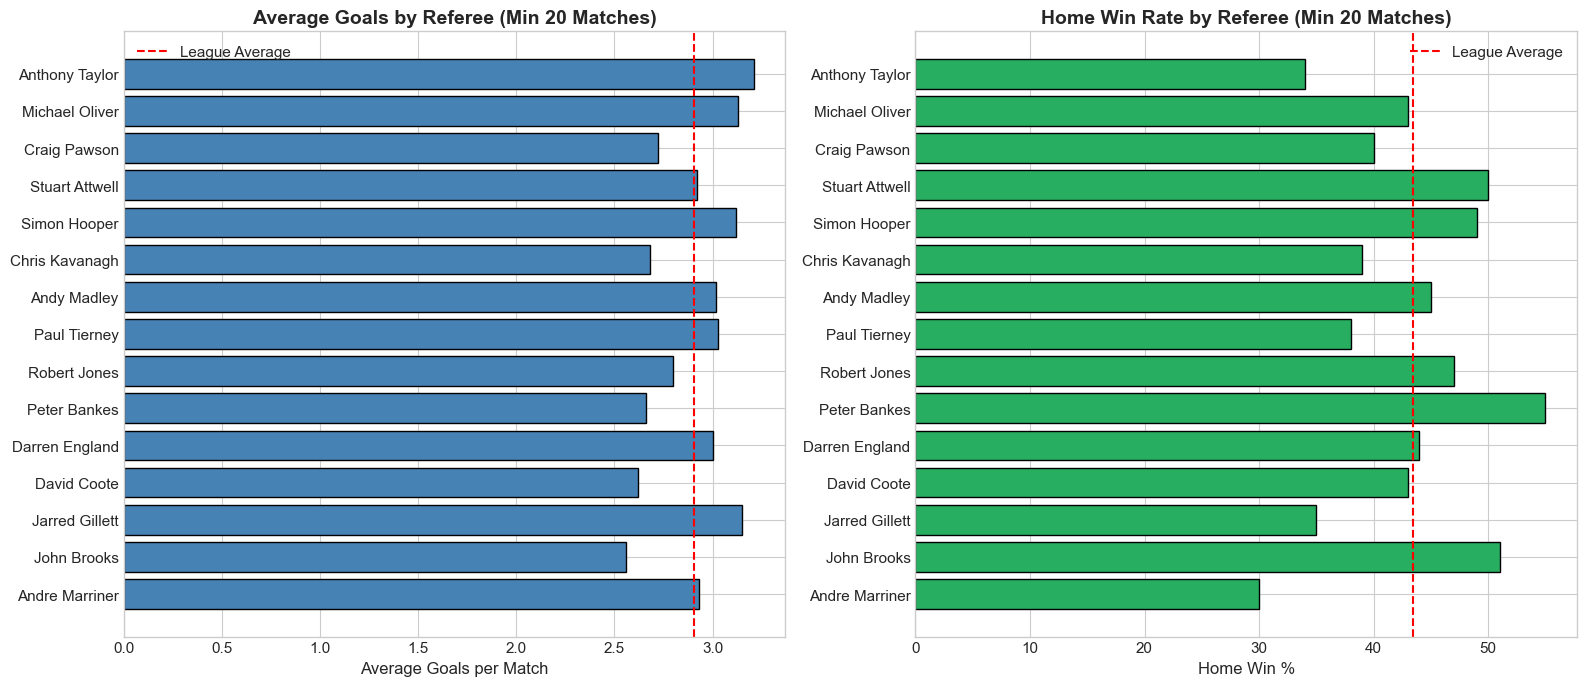


Referee Statistics:


,avg_goals,avg_home_goals,avg_away_goals,home_win_pct,matches
referee,,,,,
Anthony Taylor,3.21,1.55,1.66,0.34,161
Michael Oliver,3.13,1.65,1.48,0.43,150
Craig Pawson,2.72,1.33,1.39,0.40,123
Stuart Attwell,2.92,1.64,1.27,0.50,118
Simon Hooper,3.12,1.83,1.29,0.49,117
Chris Kavanagh,2.68,1.35,1.32,0.39,114
Andy Madley,3.02,1.72,1.29,0.45,109
Paul Tierney,3.03,1.66,1.37,0.38,104
Robert Jones,2.80,1.54,1.25,0.47,103


In [7]:
# Check if referee column exists
if 'referee' in fixtures.columns:
    referee_stats = fixtures.groupby('referee').agg({
        'total_goals': 'mean',
        'home_goals': 'mean',
        'away_goals': 'mean',
        'match_result': [lambda x: (x == 2).mean(), 'count']
    }).round(2)
    referee_stats.columns = ['avg_goals', 'avg_home_goals', 'avg_away_goals', 'home_win_pct', 'matches']
    referee_stats = referee_stats[referee_stats['matches'] >= 20]  # Min 20 matches
    referee_stats = referee_stats.sort_values('matches', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Goals by referee
    top_refs = referee_stats.head(15)
    axes[0].barh(top_refs.index, top_refs['avg_goals'], color='steelblue', edgecolor='black')
    axes[0].axvline(fixtures['total_goals'].mean(), color='red', linestyle='--', label='League Average')
    axes[0].set_xlabel('Average Goals per Match', fontsize=12)
    axes[0].set_title('Average Goals by Referee (Min 20 Matches)', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].invert_yaxis()
    
    # Home win rate by referee
    axes[1].barh(top_refs.index, top_refs['home_win_pct']*100, color='#27ae60', edgecolor='black')
    axes[1].axvline((fixtures['match_result'] == 2).mean()*100, color='red', linestyle='--', label='League Average')
    axes[1].set_xlabel('Home Win %', fontsize=12)
    axes[1].set_title('Home Win Rate by Referee (Min 20 Matches)', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('../notebooks/figures/referee_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nReferee Statistics:")
    display(referee_stats.head(15))
else:
    print("Referee column not available in dataset.")

## 7. Key Insights Summary

In [8]:
max_goals_match = fixtures.loc[fixtures['total_goals'].idxmax()]

display(Markdown(f"""
# 📊 KEY INSIGHTS - MATCH ANALYTICS

---

## ⚽ GOAL STATISTICS

| Metric | Value |
|--------|-------|
| Total Matches Analyzed | **{len(fixtures):,}** |
| Total Goals Scored | **{fixtures['total_goals'].sum():,}** |
| Average Goals per Match | **{fixtures['total_goals'].mean():.2f}** |
| Most Common Scoreline | **{fixtures['scoreline'].mode()[0]}** |

---

## 🏠 HOME ADVANTAGE

| Metric | Value |
|--------|-------|
| Home Win Rate | **{(fixtures['match_result'] == 2).mean()*100:.1f}%** |
| Away Win Rate | **{(fixtures['match_result'] == 0).mean()*100:.1f}%** |
| Draw Rate | **{(fixtures['match_result'] == 1).mean()*100:.1f}%** |
| Home Advantage | **+{((fixtures['match_result'] == 2).mean() - (fixtures['match_result'] == 0).mean())*100:.1f}%** |

---

## 🎯 xG PREDICTION

| Metric | Value |
|--------|-------|
| xG-Goals Correlation | **{fixtures['total_xg'].corr(fixtures['total_goals']):.3f}** |
| Mean Absolute Error | **{fixtures['xg_prediction_error'].abs().mean():.2f}** goals |
| Matches within ±1 goal | **{(fixtures['xg_prediction_error'].abs() <= 1).mean()*100:.1f}%** |

---

## 🔥 EXTREME MATCHES

**Highest Scoring:** {max_goals_match['home_team']} **{max_goals_match['scoreline']}** {max_goals_match['away_team']}
"""))


# 📊 KEY INSIGHTS - MATCH ANALYTICS

---

## ⚽ GOAL STATISTICS

| Metric | Value |
|--------|-------|
| Total Matches Analyzed | **2,110** |
| Total Goals Scored | **6,127.0** |
| Average Goals per Match | **2.90** |
| Most Common Scoreline | **1-1** |

---

## 🏠 HOME ADVANTAGE

| Metric | Value |
|--------|-------|
| Home Win Rate | **43.4%** |
| Away Win Rate | **33.5%** |
| Draw Rate | **23.1%** |
| Home Advantage | **+10.0%** |

---

## 🎯 xG PREDICTION

| Metric | Value |
|--------|-------|
| xG-Goals Correlation | **0.540** |
| Mean Absolute Error | **1.14** goals |
| Matches within ±1 goal | **53.9%** |

---

## 🔥 EXTREME MATCHES

**Highest Scoring:** Aston Villa **7-2** Liverpool
